# HyWaves Metamodel: Waves dataset propagation to a point.

This is a very simplified example of HyWaves toolbox. 

A waves series dataset will be propagated to a coastal point using the statistical-numerical metamodel, reducing number of SWAN-STATIONARY cases to execute, and therefore computational resources required.

SWAN scenario is a demo case based on Roi-namur (Kwajalein atoll).


## Table of contents

* [1. Workflow](#workflow)
* [2. Database](#db)
* [3. Maximum Dissimilarity Algorithm](#mda)
* [4. SWAN project](#sp)
    * [4.1. SWAN main mesh](#sp-grid-m)
    * [4.2. SWAN nested mesh](#sp-grid-n)
    * [4.3. SWAN case parameters](#sp-params)
    * [4.4. SWAN build and launch cases](#sp-cases)
    * [4.5. SWAN output visualization - main mesh](#sp-output-mg)
    * [4.6. SWAN output visualization - nested mesh](#sp-output-ng)
    * [4.7. SWAN output at point](#sp-output-point)
* [5. Radial Basis Functions reconstruction](#rbf)


<a name="workflow"></a>
##  **1. Workflow**

- Generate a waves subset using Maximum Dissimilarity Algorithm (MDA) classification from waves series dataset.
- Numerical solve waves propagations, using MDA waves subset as SWAN boundary conditions. Store propagated waves at a point.
- Feed SWAN input / output to a Radial Basis Functions model.
- Use RBF interpolator to statistically reconstruct propagation for the entire waves series dataset.


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# swan wrap module
from hywaves.wswan.wrap import SwanProject, SwanMesh, SwanWrap_STAT
from hywaves.wswan.plots.stationary import scatter_maps

# statistics
from hywaves.statistical.mda import MaxDiss_Simplified_NoThreshold
from hywaves.statistical.rbf import RBF_Reconstruction, RBF_Validation

# plotting
from hywaves.statistical.plots.mda import Plot_MDA_Data


## 2. Database <a name="db"></a>


In [2]:
# --------------------------------------
# data
p_data = op.abspath(op.join(os.path.abspath(''), '..', 'data'))
p_demo = op.join(p_data, 'demo', 'roi')

# swan main and nest1 mesh
p_swan_ext = op.join(p_demo, 'Roinamur_ext_bottom.dat')
p_swan_int = op.join(p_demo, 'Roinamur_int_bottom.dat')

# waves data
p_waves = op.join(p_demo, 'waves_historical.nc')

# roi shore (for plots)
p_shore = op.join(p_demo, 'shore.npy')
np_shore = np.load(p_shore)


In [3]:
# load waves dataset
dataset = xr.open_dataset(p_waves)  # > 300000 waves cases

# prepare waves data for SWAN STATIONARY 
dataset = dataset[['Hs', 'Tp', 'Dir']].to_dataframe()[1:]
dataset.rename(columns={"Hs":"hs", "Tp":"tp", "Dir": "dir"}, inplace=True)

print(dataset)


                                     hs        tp        dir
time                                                        
1979-01-01 00:59:59.999986560  0.526302  2.780521  68.265551
1979-01-01 02:00:00.000013440  0.836201  3.526751  70.859670
1979-01-01 03:00:00.000000000  1.063496  4.161158  73.547036
1979-01-01 03:59:59.999986560  1.221201  4.587750  74.101988
1979-01-01 05:00:00.000013440  1.346811  4.950551  73.434447
...                                 ...       ...        ...
2020-06-30 20:00:00.000013312  0.978911  8.029230  63.577090
2020-06-30 21:00:00.000000000  0.976827  8.030317  62.778190
2020-06-30 21:59:59.999986688  0.973691  8.029948  62.099051
2020-06-30 23:00:00.000013312  0.970341  8.023516  61.521886
2020-07-01 00:00:00.000000000  0.967821  8.014340  61.103933

[363768 rows x 3 columns]


## 3. Maximum Dissimilarity Algorithm (MDA) classification <a name="mda"></a>


In [4]:
# --------------------------------------
# Set MDA parameters

# variables to use
vns = ['hs', 'tp', 'dir']

# subset size, scalar and directional indexes
n_subset = 125            # subset size (very small for this conceptual example)
ix_scalar = [0, 1]        # hs, tp
ix_directional = [2]      # dir



MaxDiss waves parameters: 363768 --> 125

   MDA centroids: 125/125



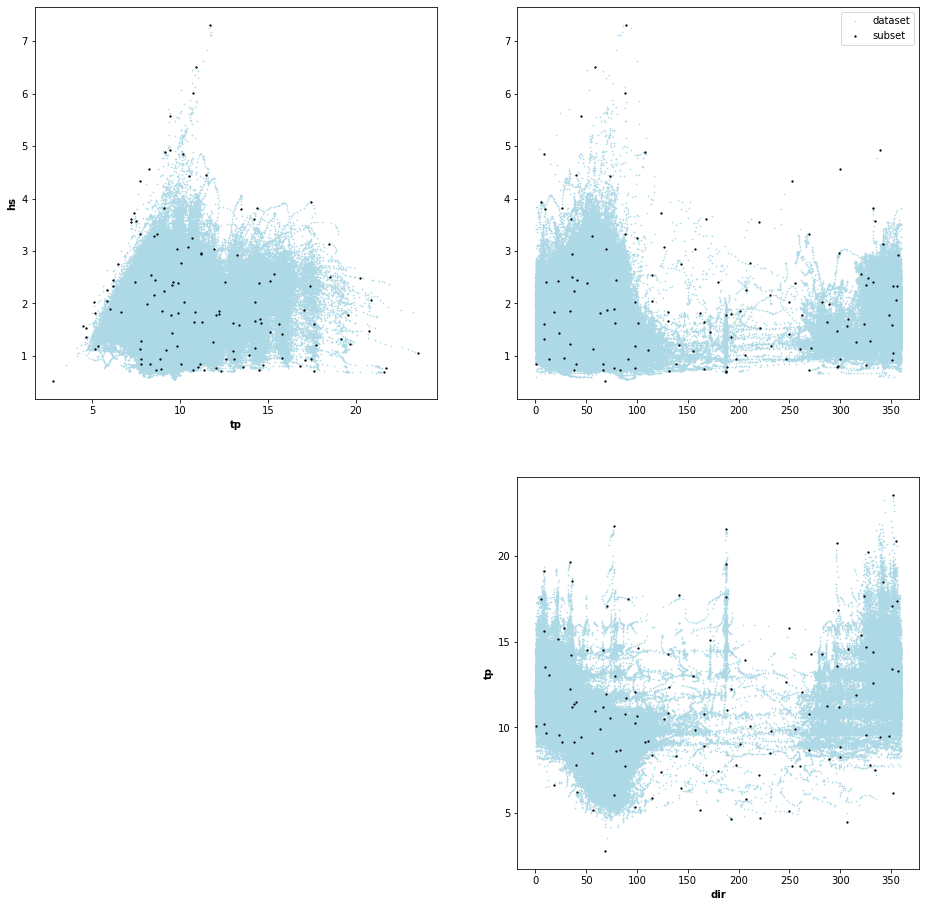

In [5]:
# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(dataset[vns].values[:], n_subset, ix_scalar, ix_directional)
subset = pd.DataFrame(data=sel, columns=vns)

# plot classification
Plot_MDA_Data(dataset, subset);


In [6]:
# fill/fix subset variables for SWAN execution

subset['spr'] = 40  # set directional spread
subset.rename(columns={'tp':'per'}, inplace=True)  # rename Tp for swan wrapper


## 4. SWAN: Project <a name="sp"></a>


In [7]:
# --------------------------------------
# SWAN project 

p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_01_demo'                 # project name

sp = SwanProject(p_proj, n_proj)


### 4.1. SWAN: main grid description <a name="sp-grid-m"></a>


In [8]:
# --------------------------------------
# SWAN main mesh
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': 166.6159,  # x origin
    'ypc': 8.4105,    # y origin
    'alpc': 0,        # x-axis direction 
    'xlenc': 1.3722,  # grid length in x
    'ylenc': 1.175,   # grid length in y
    'mxc': 137,       # number mesh x
    'myc': 118,       # number mesh y
    'dxinp': 0.01,    # size mesh x
    'dyinp': 0.01,    # size mesh y
}

# depth value
main_mesh.depth = np.loadtxt(p_swan_ext)

# computational grid description
main_mesh.cg = main_mesh.dg.copy()

sp.set_main_mesh(main_mesh)


### 4.2. SWAN: nested grid description <a name="sp-grid-n"></a>


In [9]:
# --------------------------------------
# SWAN nest1 mesh
mesh_nest1 = SwanMesh()

# depth grid description
mesh_nest1.dg = {
    'xpc': 167.4059,
    'ypc': 9.3505,
    'alpc': 0,
    'xlenc': 0.12,
    'ylenc': 0.08,
    'mxc': 120,
    'myc': 80,
    'dxinp': 0.001,
    'dyinp': 0.001,
}

# depth value
mesh_nest1.depth = np.loadtxt(p_swan_int)

# computational grid description
mesh_nest1.cg = mesh_nest1.dg.copy()

sp.set_nested_mesh_list([mesh_nest1])


### 4.3. SWAN: case parameters <a name="sp-params"></a>


In [10]:
# --------------------------------------
# SWAN parameters (sea level, jonswap gamma...)

input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',

    'coords_mode': 'SPHERICAL',
    'coords_projection': 'CCM',
    
    'boundw_jonswap': 10,
    'boundw_period': 'PEAK',

    'boundn_mode': 'CLOSED',

    'physics':[
        'FRICTION JONSWAP',
        'BREAKING',
    ],

    'numerics':[
        'OFF QUAD',
    ]
}

sp.set_params(input_params)


### 4.4. SWAN: Build and launch waves cases <a name="sp-cases"></a>


In [11]:
# SWAN project wrapper
sw = SwanWrap_STAT(sp)

# build and launch cases
sw.build_cases(subset)
sw.run_cases()


### 4.5. SWAN: output visualization - main mesh <a name="sp-output-mg"></a>


<xarray.Dataset>
Dimensions:     (case: 125, lat: 118, lon: 137)
Coordinates:
  * lon         (lon) float64 166.6 166.6 166.6 166.6 ... 168.0 168.0 168.0
  * lat         (lat) float64 8.411 8.42 8.43 8.44 ... 9.546 9.556 9.566 9.576
  * case        (case) int64 0 1 2 3 4 5 6 7 ... 117 118 119 120 121 122 123 124
Data variables:
    Tm02        (case, lat, lon) float32 10.287976 10.286682 ... 4.166347
    Dir         (case, lat, lon) float32 109.637405 109.76996 ... 212.3155
    Tp          (case, lat, lon) float32 11.665952 11.665943 ... 4.597738
    FSpr        (case, lat, lon) float32 0.7489048 0.7488757 ... 0.77345073
    PkDir       (case, lat, lon) float32 92.5 92.5 92.5 ... 272.49997 177.5
    Dspr        (case, lat, lon) float32 29.849676 29.592379 ... 48.481728
    WaterLevel  (case, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Hsig        (case, lat, lon) float32 5.974939 5.9692597 ... 1.0410175
    RTpeak      (case, lat, lon) float32 11.752515 11.752515 ... 

/Users/admin/Projects/BlueMath/HybridModels/HyWaves/venv/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


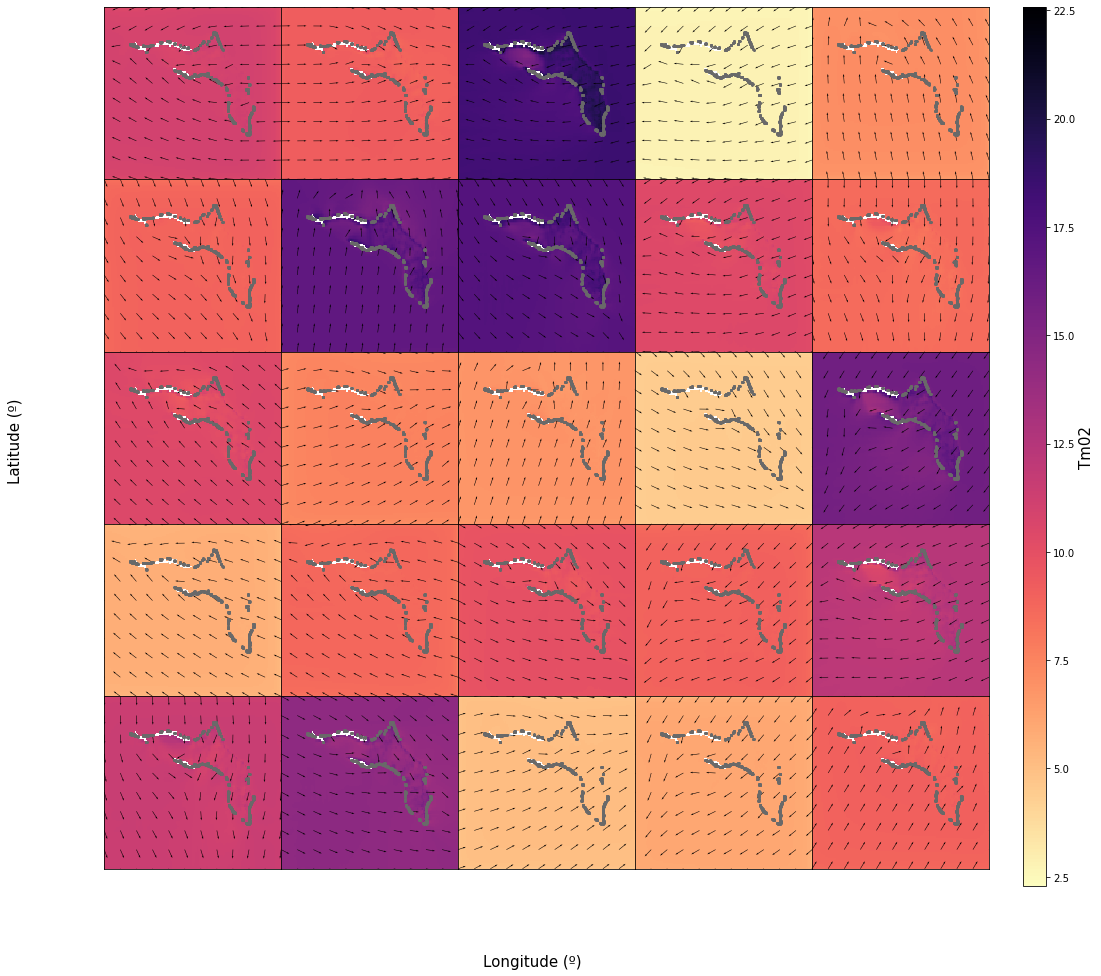

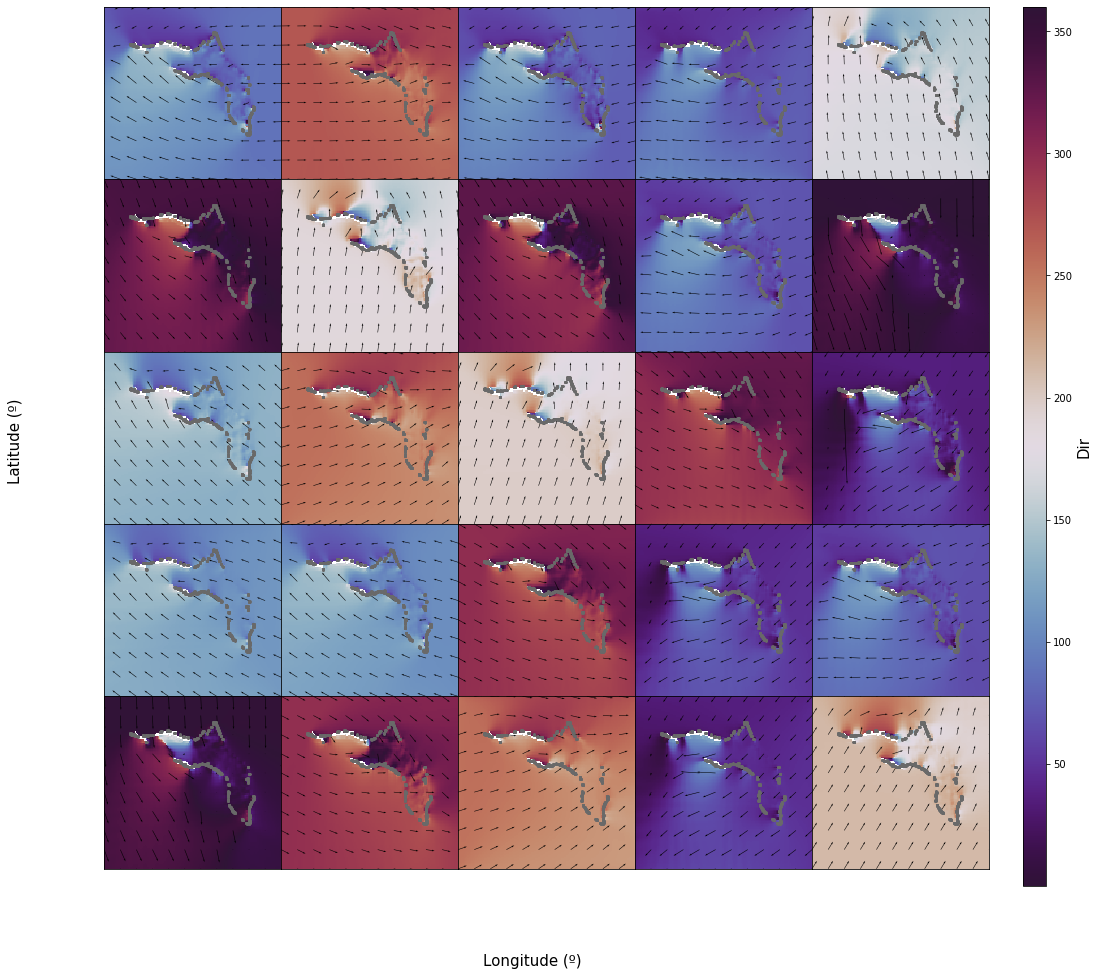

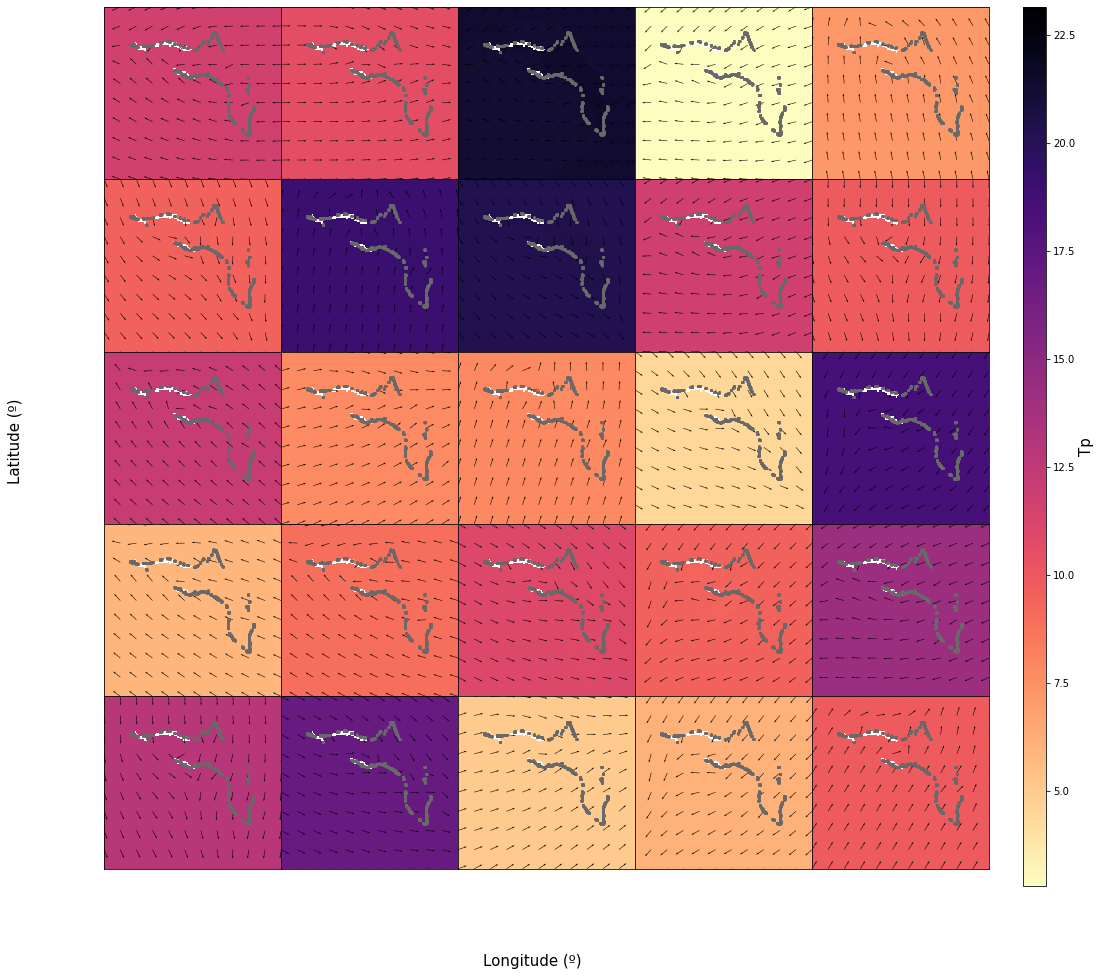

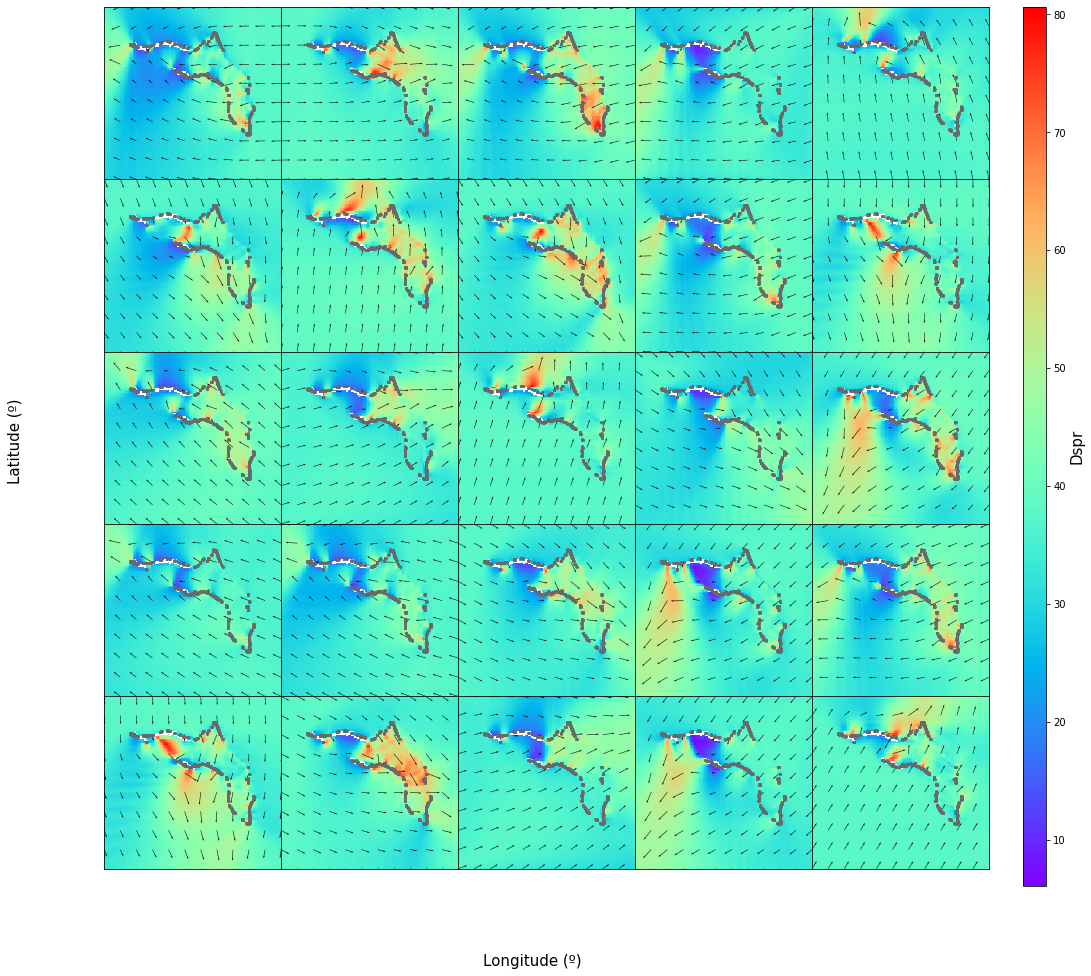

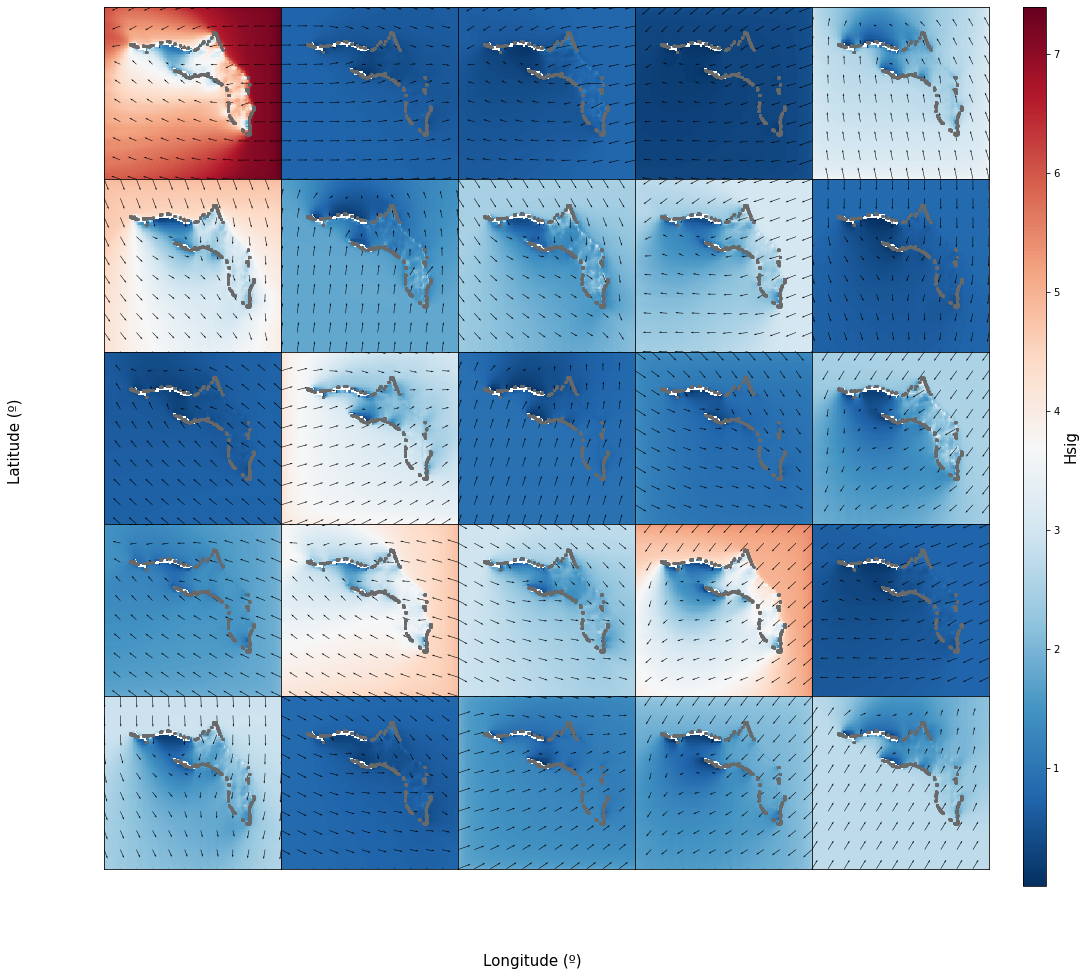

In [12]:
# extract output for main mesh
xds_out = sw.extract_output()
print(xds_out)

# plot scatter maps
scatter_maps(xds_out, n_cases=25, np_shore=np_shore);


### 4.6. SWAN: output visualization - nested mesh <a name="sp-output-ng"></a>


<xarray.Dataset>
Dimensions:     (case: 125, lat: 80, lon: 120)
Coordinates:
  * lon         (lon) float64 167.4 167.4 167.4 167.4 ... 167.5 167.5 167.5
  * lat         (lat) float64 9.351 9.351 9.353 9.354 ... 9.427 9.428 9.429 9.43
  * case        (case) int64 0 1 2 3 4 5 6 7 ... 117 118 119 120 121 122 123 124
Data variables:
    Tm02        (case, lat, lon) float32 10.831408 10.8654585 ... 4.653763
    Dir         (case, lat, lon) float32 54.182266 53.941925 ... 215.13121
    Tp          (case, lat, lon) float32 11.662048 11.665509 ... 4.6082745
    FSpr        (case, lat, lon) float32 0.7467098 0.749933 ... 0.84715956
    PkDir       (case, lat, lon) float32 32.5 27.499985 ... 267.5 267.5
    Dspr        (case, lat, lon) float32 38.537163 39.880123 ... 31.983719
    WaterLevel  (case, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Hsig        (case, lat, lon) float32 3.1314583 3.1611438 ... 0.44084904
    RTpeak      (case, lat, lon) float32 11.752515 11.752515 ... 

/Users/admin/Projects/BlueMath/HybridModels/HyWaves/venv/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


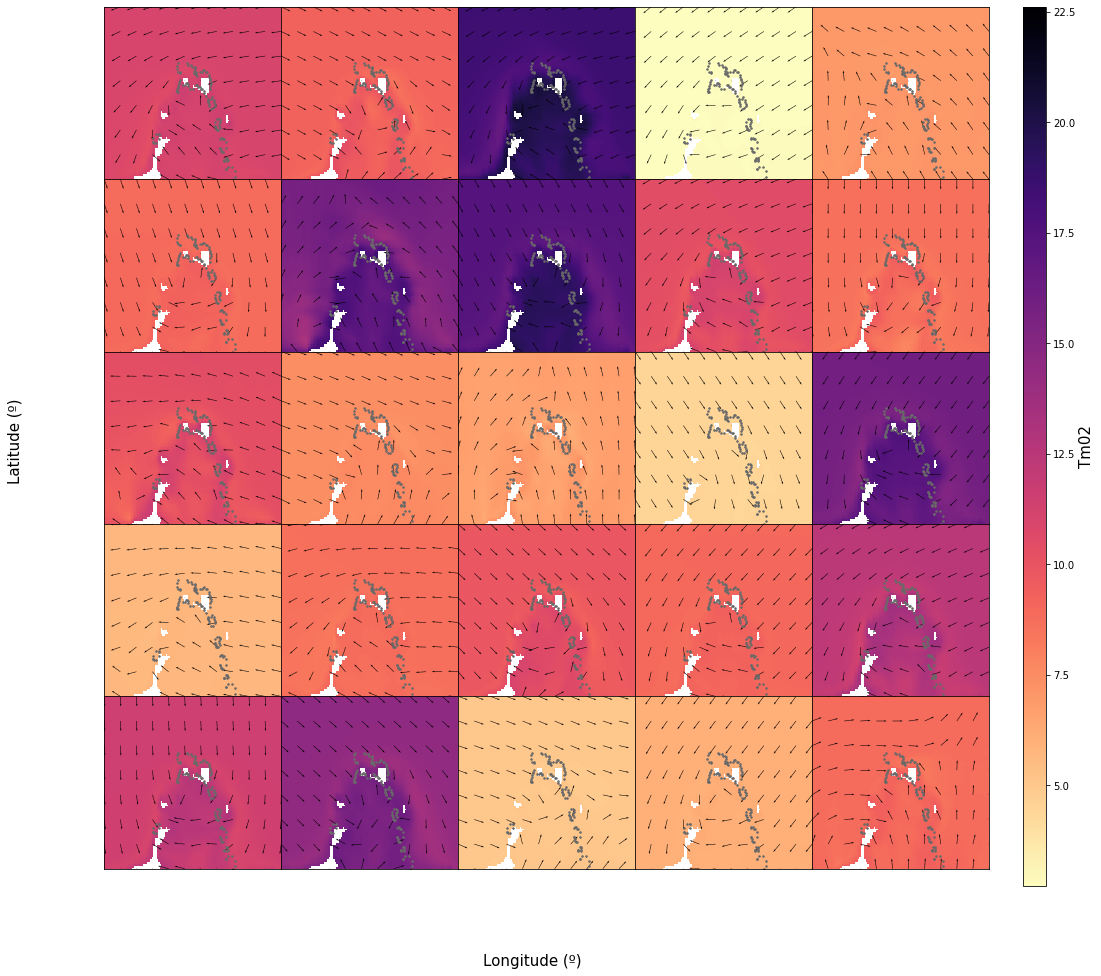

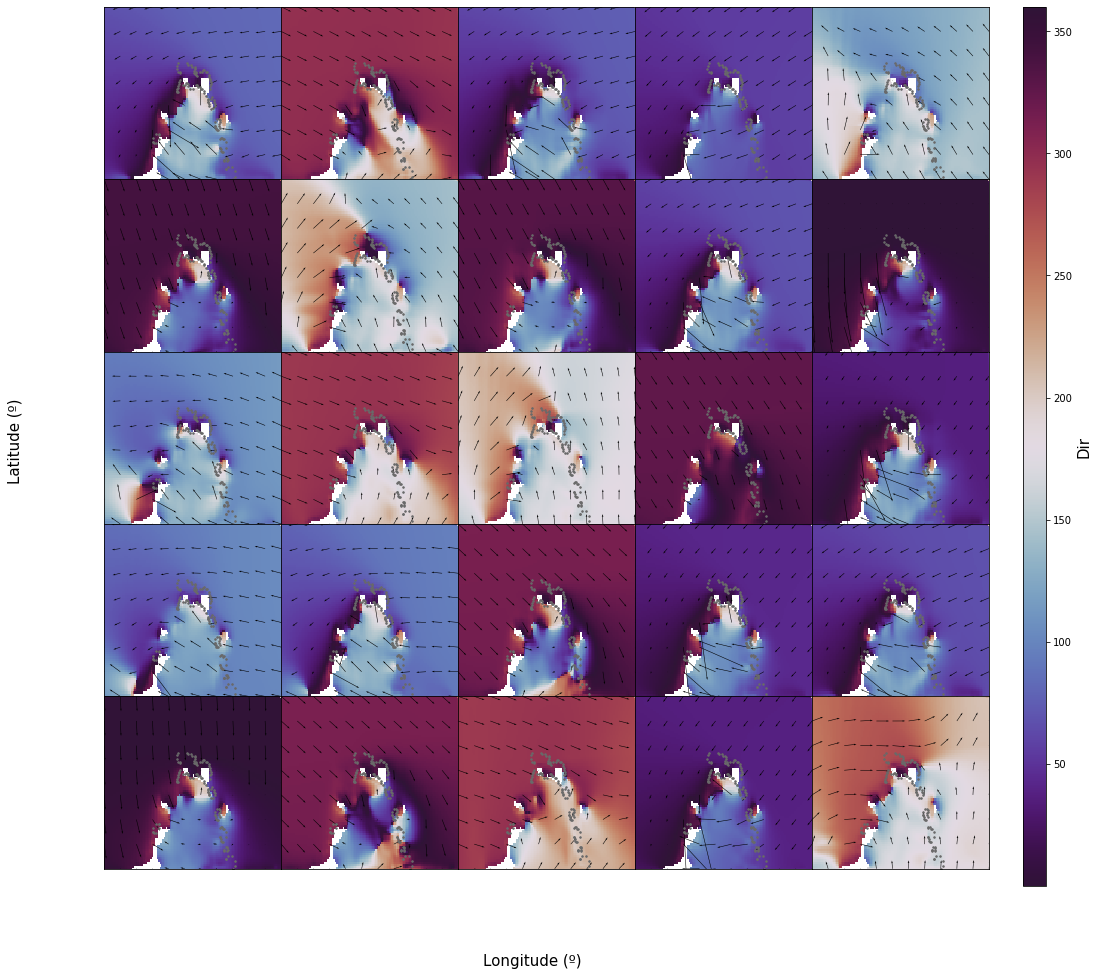

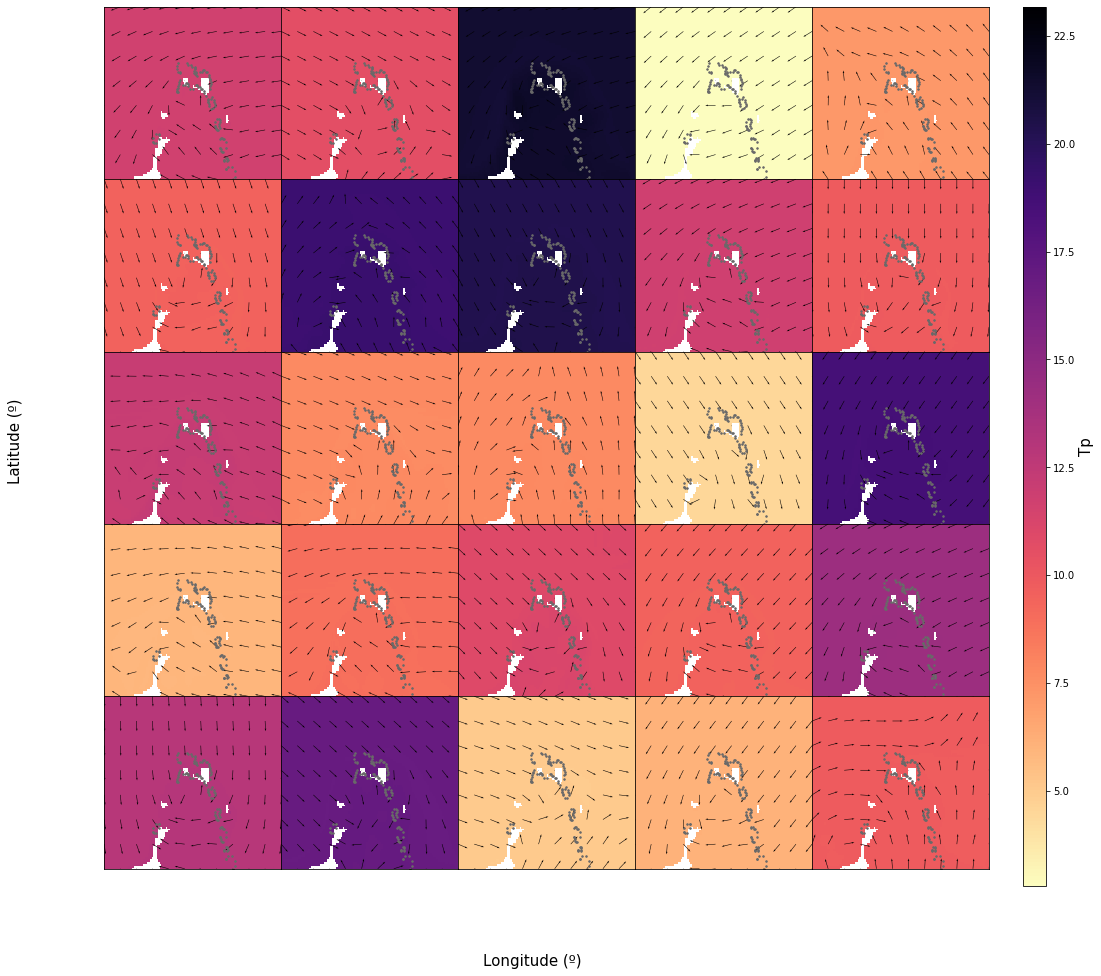

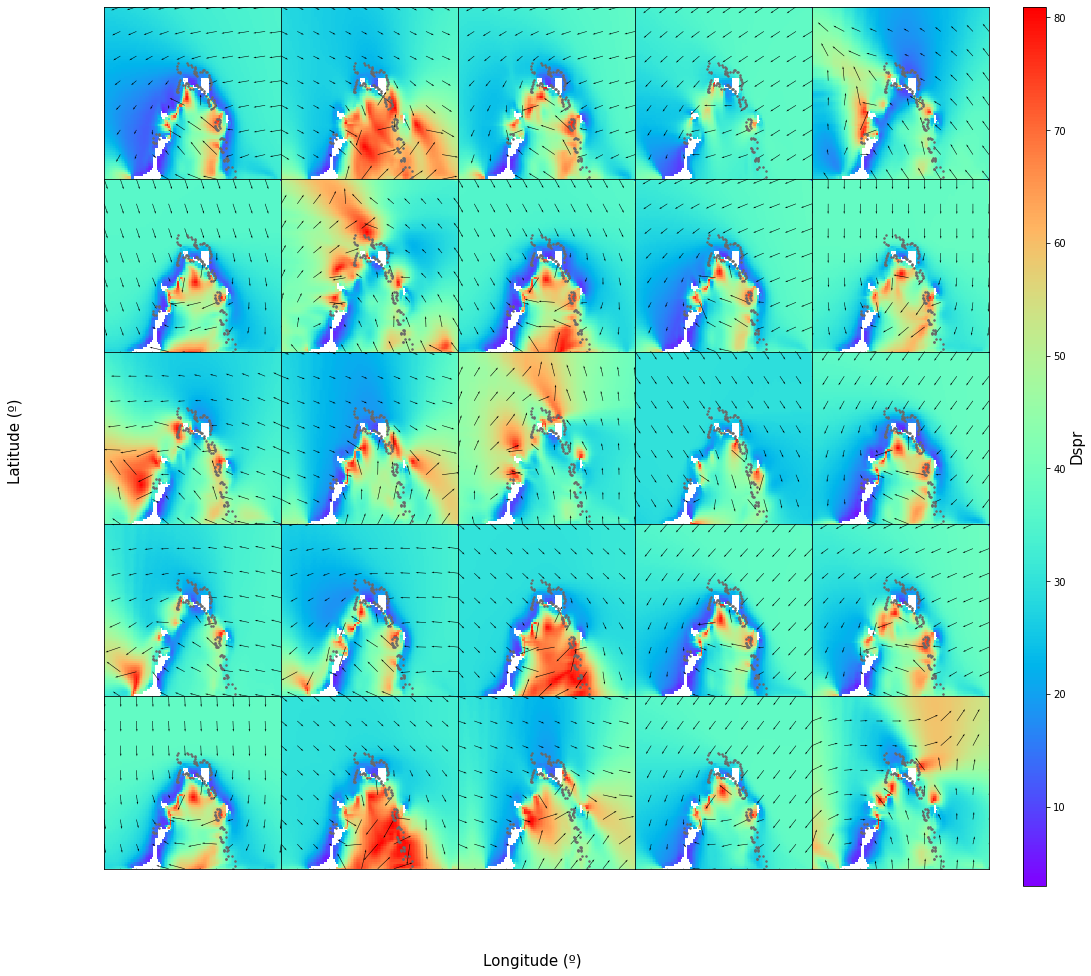

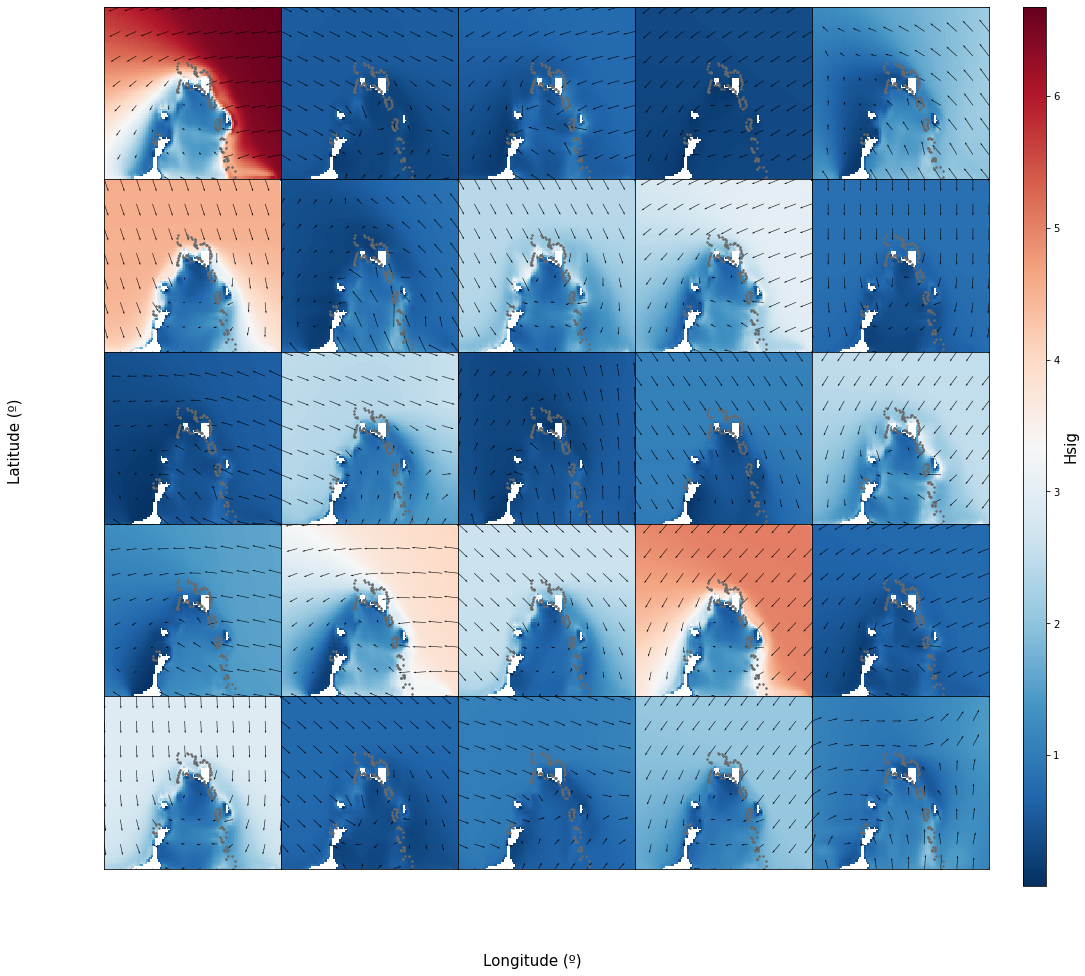

In [13]:
# extract output for nested mesh
xds_out_n1 = sw.extract_output(mesh=sp.mesh_nested_list[0])
print(xds_out_n1)

# plot scatter maps
scatter_maps(xds_out_n1, n_cases=25, np_shore=np_shore);


### 4.7. SWAN: extract output at selected point <a name="sp-output-point"></a>


In [14]:
# point to reconstruct 
ix_lon, ix_lat = 62, 66

# Extract propagated waves at point (from nest1 mesh)
target = xds_out_n1.isel({'lon':ix_lon, 'lat':ix_lat}).to_dataframe()

# this will be used as RBF target while fitting statistical model
print(target)


           lon     lat       Tm02         Dir         Tp      FSpr  \
case                                                                 
0     167.4679  9.4165  11.049024   77.144119  11.667482  0.767133   
1     167.4679  9.4165   9.276402  298.248535  10.640612  0.727197   
2     167.4679  9.4165  18.416162   66.468201  21.290634  0.711504   
3     167.4679  9.4165   2.790912   55.387573   2.811212  0.850988   
4     167.4679  9.4165   7.030385  117.977463   7.238998  0.816342   
...        ...     ...        ...         ...        ...       ...   
120   167.4679  9.4165   7.887377   73.458710   8.644674  0.735797   
121   167.4679  9.4165  12.307631  299.677643  14.133092  0.727777   
122   167.4679  9.4165  10.424542  295.510437  11.803345  0.721673   
123   167.4679  9.4165   7.739235   94.479187   8.187388  0.740622   
124   167.4679  9.4165   4.545937  276.214569   4.594088  0.809933   

           PkDir       Dspr  WaterLevel      Hsig     RTpeak       Depth  \
case         

## 5. Radial Basis Function reconstruction <a name="rbf"></a>


In [15]:
# Prepare data
subset.rename(columns={'per':'tp'}, inplace=True)  # reset subset variable name

# select dataset and subset variables
vns_ds = ['hs', 'tp', 'dir']

# select target variables
vns_tgt = ['Hsig', 'Tp', 'Dir']

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo)
ix_directional_target = [2]   # directional (Dir)


In [16]:
# Obtain statistical propagation output for the entire waves dataset
output = RBF_Reconstruction(
    subset[vns_ds].values, ix_scalar_subset, ix_directional_subset,
    target[vns_tgt].values, ix_scalar_target, ix_directional_target,
    dataset[vns_ds].values,
)

# mount output as pandas.DataFrame
output = pd.DataFrame(data=output, columns=vns_tgt, index=dataset.index)

print(output)


ix_scalar: 0,  optimization: 0.86 | interpolation: 16.19, sigma_opt: 0.37
ix_scalar: 1,  optimization: 2.14 | interpolation: 17.11, sigma_opt: 0.10
ix_directional: 2,  optimization: 1.65 | interpolation: 32.22, sigma_opt: x 0.36, y 0.28
                                   Hsig        Tp        Dir
time                                                        
1979-01-01 00:59:59.999986560  0.346912  2.811212  55.387574
1979-01-01 02:00:00.000013440  0.601640  3.537798  58.521256
1979-01-01 03:00:00.000000000  0.806035  4.146035  62.089600
1979-01-01 03:59:59.999986560  0.961516  4.559256  63.780880
1979-01-01 05:00:00.000013440  1.095864  4.912910  64.313898
...                                 ...       ...        ...
2020-06-30 20:00:00.000013312  0.981626  7.893931  61.413126
2020-06-30 21:00:00.000000000  0.985114  7.893624  60.851257
2020-06-30 21:59:59.999986688  0.986791  7.892428  60.368726
2020-06-30 23:00:00.000013312  0.987503  7.885644  59.951860
2020-07-01 00:00:00.000000000  